In [1]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob

In [2]:
ds=xr.open_dataset("/seq001/data/roms_his_DailyNudge_2018_5daymn_grid_vars.nc")
def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut

grid = makeROMSGridObject(ds)
dz=ds['dz_w']
del(ds)


In [3]:
ds=xr.open_dataset("/seq001/data/roms_his_DailyNudge_2018_5daymn_processed.nc")

In [4]:
ds['dz_w']=dz

In [2]:
#or
ds=xr.open_dataset("/seq001/data/roms_his_DailyNudge_2018_5daymn.nc")
ds=ds.set_coords(("lon_rho","lat_rho"))
# do special processing for ROMS formatting
ds['hc']=20


def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])


    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
    Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
    z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time','s_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds["z_rho0"] = ds.z_rho0.fillna(0)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi
    
    
    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])
    del(Zo_rho)
    del(z_rho)
    del(Zo_w)
    del(z_w)

    return ds


# if loading a multi-file dataset, then process the grid with this.
ds = processROMSGrid(ds)
def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut

grid = makeROMSGridObject(ds)

In [5]:
# drop some variables to speed up loading!
ds = ds[['dx','dy','dz','z_rho0','temp','dz_w']]
# ds = ds.drop('z_rho')

# Let's load the u,v velocities to speed this up...
ds.load()

<xarray.Dataset>
Dimensions:     (eta_rho: 600, xi_rho: 800, ocean_time: 73, s_rho: 31, s_w: 32)
Coordinates:
    z_rho0      (eta_rho, xi_rho, s_rho) float64 0.0 0.0 0.0 ... -0.8484 -0.2858
  * ocean_time  (ocean_time) datetime64[ns] 2025-12-30 2026-01-04 ... 2026-12-25
  * s_rho       (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
  * s_w         (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.06452 -0.03226 0.0
    lat_rho     (eta_rho, xi_rho) float64 -30.0 -30.0 -30.0 ... -24.01 -24.01
    lon_rho     (eta_rho, xi_rho) float64 151.5 151.5 151.5 ... 159.5 159.5
    z_w         (ocean_time, s_w, eta_rho, xi_rho) float64 0.0 0.0 ... -0.008157
    z_rho       (ocean_time, s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... -0.2681
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    dx          (eta_rho, xi_rho) float64 963.0 963.0 ... 1.016e+03 1.016e+03
    dy          (eta_rho, xi_rho) float64 1.112e+03 1.112e+03 ... 1.112e+03
    dz          (ocean_time, s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... 0.5342
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float32 nan nan ... 24.87
    dz_w        (ocean_time, s_w, eta_rho, xi_rho) float64 0.0 0.0 ... 0.2681
Attributes: (12/38)
    CDI:                        Climate Data Interface version 2.0.4 (https:/...
    Conventions:                CF-1.4, SGRID-0.3
    file:                       roms_his_0020.nc
    format:                     netCDF-3 64bit offset file
    type:                       ROMS grid file
    title:                      South-east Queensland, 1/100 (900m) degree re...
    ...                         ...
    history:                    Mon Feb 19 09:22:01 2024: ncks -A ROMS_grid_c...
    ana_file:                   ROMS/Functionals/ana_btflux.h
    CPP_options:                SEQLD, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE,...
    CDO:                        Climate Data Operators version 2.0.4 (https:/...
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...
    history_of_appended_files:  Mon Feb 19 09:22:01 2024: Appended file ROMS_...

In [6]:
# first calculate some required metrics

ds["dz0"] = ds.dz.mean(dim='ocean_time')
ds["dz_w0"]=ds.dz_w.mean(dim='ocean_time')
#ds["dx"] = ds.dx
ds["z_rho0"] = ds.z_rho0.fillna(0)
ds["z_w0"]=ds.z_w.mean(dim='ocean_time').fillna(0)
#ds["s_w"] = ds.s_w
ds["s_w3"],dump = xr.broadcast(ds.s_w,ds.lon_rho)

In [7]:
dTdz = grid.diff(ds.temp.mean(dim='ocean_time'),'Z',boundary='fill',fill_value=np.nan)/ds.dz_w0

ds["z_dtdzmax"] = ds.z_w0.where(ds.s_w3==(dTdz).idxmax(dim='s_w',skipna=True)).max(dim='s_w')

In [8]:
#try without means
ds["z_rho0"] = ds.z_rho0.fillna(0)
ds["z_w"]=ds.z_w.fillna(0)
ds["s_w3"],dump = xr.broadcast(ds.s_w,ds.lon_rho)

dTdz = grid.diff(ds.temp,'Z',boundary='fill',fill_value=np.nan)/ds.dz_w
ds["z_dtdzmax"] = ds.z_w.where(ds.s_w3==(dTdz).idxmax(dim='s_w',skipna=True)).max(dim='s_w')

In [11]:
ds.z_dtdzmax.isel(eta_rho=100,xi_rho=220).mean(dim='ocean_time')

<xarray.DataArray 'z_dtdzmax' ()>
array(-17.92742305)
Coordinates:
    lat_rho  float64 -29.0
    lon_rho  float64 153.7

In [1]:
plt.figure(figsize=[10,10])
plt.plot(ds.temp.isel(eta_rho=300,xi_rho=220).mean(dim='ocean_time'),ds.z_rho0.isel(eta_rho=300,xi_rho=220))
plt.plot(100*dTdz.isel(eta_rho=300,xi_rho=220),ds.z_w0.isel(eta_rho=300,xi_rho=220))
plt.axhline(ds.z_dtdzmax.isel(eta_rho=300,xi_rho=220),color='C1')
# plt.plot([10,22],[SSHSST.dTdz.mean(dim=['ocean_time']).isel(eta_rho=125,xi_rho=140),SSHSST.dTdz.mean(dim=['ocean_time']).isel(eta_rho=125,xi_rho=140)])
plt.ylim(-100,0)

NameError: name 'plt' is not defined

<Figure size 640x480 with 0 Axes>

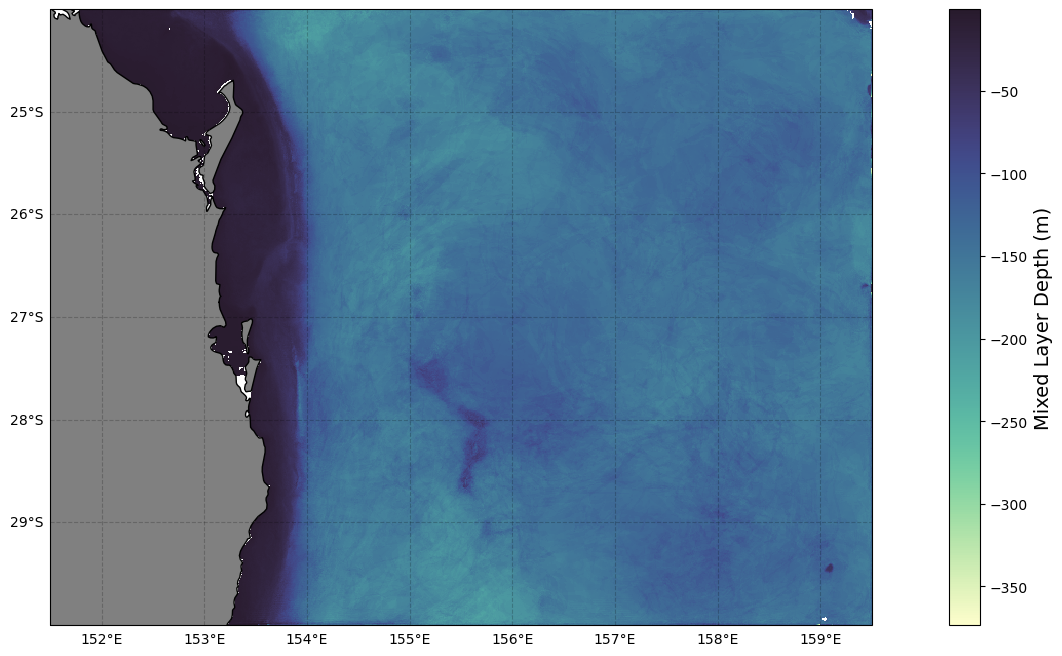

In [18]:
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,8])
ax = None

ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
Coast = cfeature.NaturalEarthFeature(category='physical',scale='10m',facecolor='none', name='coastline')
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im =ds.z_dtdzmax.mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep') 
ax.set_extent([151.5, 159.5, -30, -24])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False

cbar = fig.colorbar(im) 
cbar.set_label('Mixed Layer Depth (m)',fontsize=14)

<Figure size 640x480 with 0 Axes>

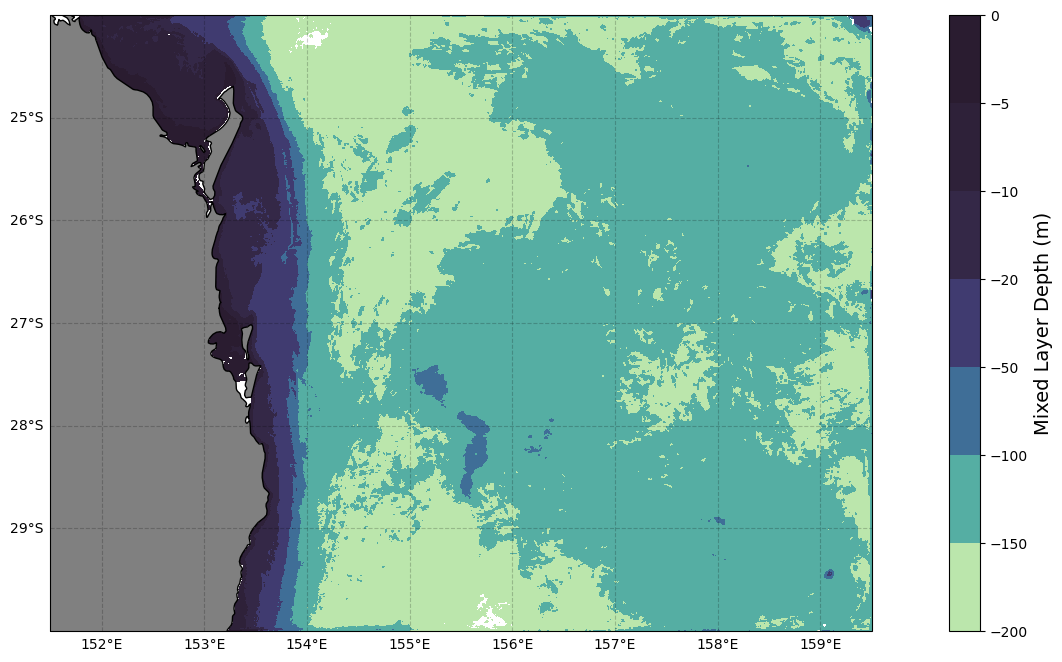

In [25]:
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,8])
ax = None

ax = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
Coast = cfeature.NaturalEarthFeature(category='physical',scale='10m',facecolor='none', name='coastline')
ax.add_feature(Coast, edgecolor='black',facecolor='gray')
#im =ds.z_dtdzmax.mean(dim='ocean_time').contour(ax=ax,x='lon_rho',y='lat_rho',add_colorbar=False,cmap='cmo.deep',vmin=-200,vmax=0) 
co=ax.contourf(ds.lon_rho,ds.lat_rho,ds.z_dtdzmax.mean(dim='ocean_time'),cmap='cmo.deep',levels=[-200,-150,-100,-50,-20,-10,-5,0])
ax.set_extent([151.5, 159.5, -30, -24])
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False

cbar = fig.colorbar(co) 
cbar.set_label('Mixed Layer Depth (m)',fontsize=14)